###Analyse

* Wat is het probleem? 
   - We moeten voorspellen of iemand zal sterven na hartfalen.
* Wat voor labels heb je?
  - Death event
* Soorten data/features?
De features bestaan uit tekst en getallen, de features zijn:
  - De data bestaat uit cijfers/nummers.
Features:
  - age: Age
  - anaemia: Decrease of red blood cells or hemoglobin (boolean)
  - creatinine_phosphokinase: Level of the CPK enzyme in the blood (mcg/L)
  - diabetes: If the patient has diabetes (boolean)
  - ejection_fraction: Percentage of blood leaving the heart at each contraction (percentage)
  - high_blood_pressure: If the patient has hypertension (boolean)
  - platelets: Platelets in the blood (kiloplatelets/mL)
  - serum_creatinine: Level of serum creatinine in the blood (mg/dL)
  - serum_sodium: Level of serum sodium in the blood (mEq/L)
  - sex: Woman or man (binary)


###Voorspelling:
* Welke classifier zal het beste zijn en waarom? 
  * De random fores, omdat deze over het algemeen goede accuuraatheid heeft en het goed doet op kleinere datasets. 
* Welke hyperparameters zijn relevant en waarom?
  - De (max) leaf nodes voor allebei de trees, dit omdat het overfitting voorkomt.

###Methoden
* Welke preprocessing stappen zijn nodig?
  - Er zal gekeken moeten worden welke kolommen echt nodig zijn. Dus welke een hoge correlatie hebben met het overleven (of juist niet) van hartfalen. verder zal de data geschaald moeten worden.
* Welke classifiers ga je vergelijken? (Minimaal 2 per dataset)
  - random forest en de decision tree.
* Welke performance metric is passend?
  - De confusie matrix kan goed laten zien wat de balans is tussen de true positives en negatives en false positives en negatives.
  - De F1 score laat een mooie balans zien tussen al deze waardes, dus gebruiken we deze.

###Resultaten

*Niet alleen beste resultaat geven, het gaat juist ook om de vergelijking/verbetering!*
* Minimaal 1 visualisatie/plotje per dataset.
* Evaluatie/conclusie
* Welke classifier leverde beste resultaat op?
* Klopt dit met je voorspelling? Waarom wel/niet?

In [19]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.metrics import confusion_matrix, accuracy_score,precision_score,recall_score,f1_score, classification_report
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
from mlxtend.plotting import plot_confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
import math

%matplotlib inline

In [20]:
df = pd.read_csv("/content/drive/My Drive/minor/ML/heart_failure.csv", sep =",")

In [21]:
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [22]:
# Kijk of er null-waarden zijn
df.isnull().sum()

age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
DEATH_EVENT                 0
dtype: int64

Er zijn geen null-waardes, dat is goed.

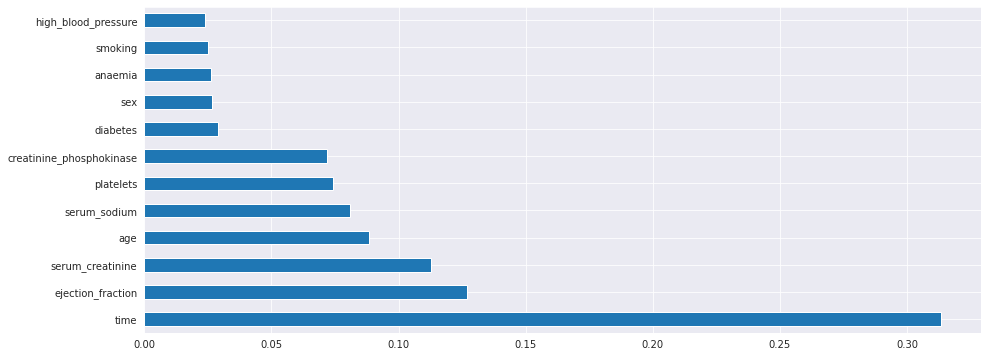

In [23]:
# Feature Selection

plt.rcParams['figure.figsize']=15,6 
sns.set_style("darkgrid")

x = df.iloc[:, :-1]
y = df.iloc[:,-1]

from sklearn.ensemble import ExtraTreesClassifier
model = ExtraTreesClassifier()
model.fit(x,y)
feat_importances = pd.Series(model.feature_importances_, index=x.columns)
feat_importances.nlargest(12).plot(kind='barh')
plt.show()

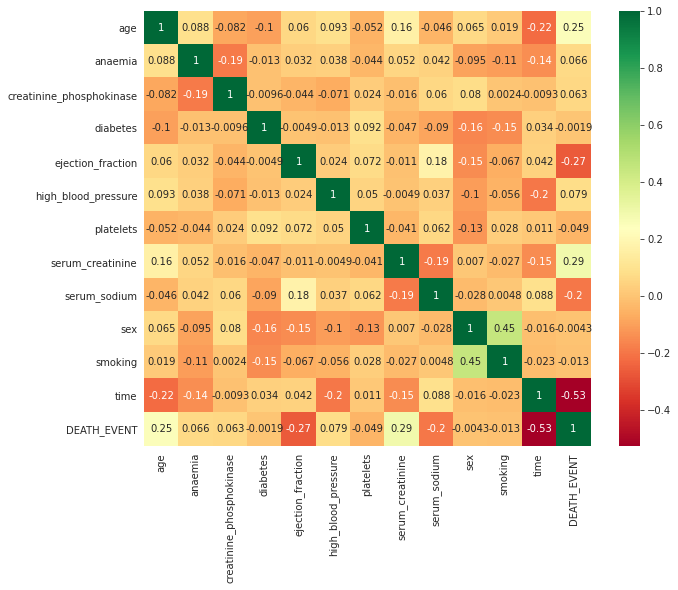

age                         0.253729
anaemia                     0.066270
creatinine_phosphokinase    0.062728
diabetes                   -0.001943
ejection_fraction          -0.268603
high_blood_pressure         0.079351
platelets                  -0.049139
serum_creatinine            0.294278
serum_sodium               -0.195204
sex                        -0.004316
smoking                    -0.012623
time                       -0.526964
DEATH_EVENT                 1.000000
Name: DEATH_EVENT, dtype: float64


In [24]:
# Corr matrix 
corr= df.corr()
sns.heatmap(corr,annot=True, cmap='RdYlGn')
fig=plt.gcf()
fig.set_size_inches(10,8)
plt.show()
print(corr['DEATH_EVENT'])


Hieruit is te zien dat age, serum_creatinine, time en ejection_fraction een hoge correlatie hebben met het overlijden. Deze zullen we gebruiken als features.

In [25]:
corr[abs(corr['DEATH_EVENT']) > 0.1]['DEATH_EVENT']

age                  0.253729
ejection_fraction   -0.268603
serum_creatinine     0.294278
serum_sodium        -0.195204
time                -0.526964
DEATH_EVENT          1.000000
Name: DEATH_EVENT, dtype: float64

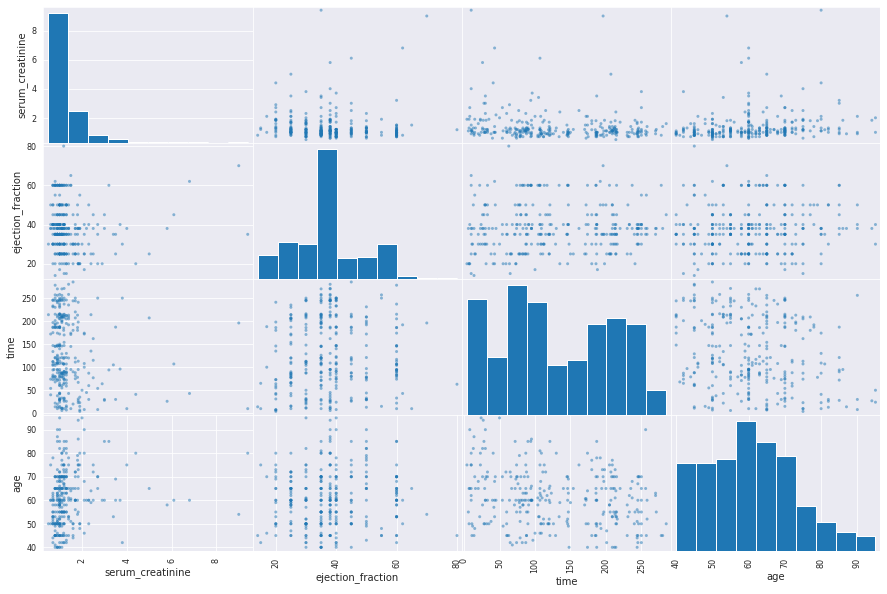

In [26]:
# Scatter matrix
features = df[['serum_creatinine', 'ejection_fraction', 'time', 'age']]
scatter_matrix(features, figsize = (15, 10))
plt.show()

De data is niet normaal-verdeeld, maar omdat we tree classifiers gaan gebruiken is normalisatie of 'scaling' niet nodig. Dit omdat het weinig effect heeft op de resultaten van tree-based algoritmes. 

In [27]:
X = features
y = df['DEATH_EVENT'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 6)
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler

sc=StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)
print(X.shape)
print(y.shape)

(299, 4)
(299,)


# Decision tree model

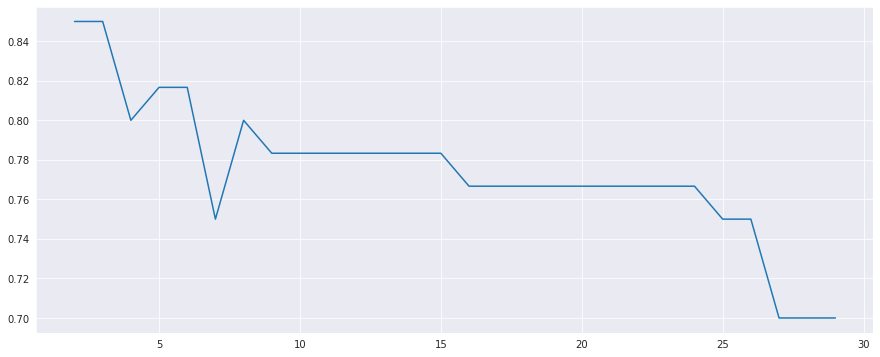

In [28]:
# Finding the optimum number of max_leaf_nodes // from bron 1
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
list1 = []
for leaves in range(2,30):
    classifier = DecisionTreeClassifier(max_leaf_nodes = leaves, random_state=0)
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    list1.append(accuracy_score(y_test,y_pred))
plt.plot(list(range(2,30)), list1)
plt.show()

In [29]:
#Decision tree
dtc = DecisionTreeClassifier(max_leaf_nodes=3)
dtc.fit(X_train,y_train)
dtc_pred = dtc.predict(X_test)

<Figure size 1080x432 with 0 Axes>

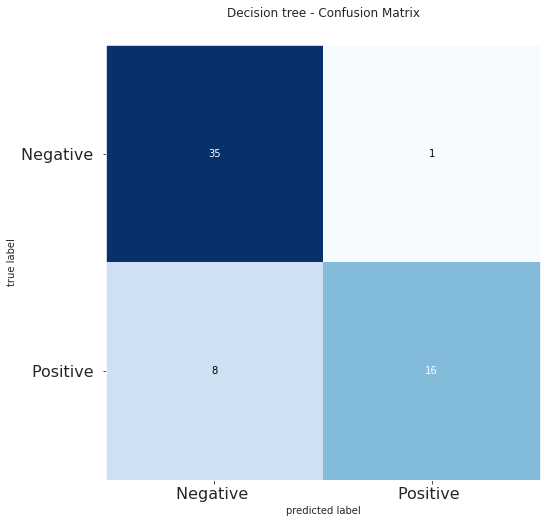

Precision: 0.941176
Recall: 0.666667
F1 score: 0.780488


In [30]:
cm = confusion_matrix(y_test, dtc_pred)
plt.figure()
plot_confusion_matrix(cm, figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues)
plt.title("Decision tree - Confusion Matrix")
plt.xticks(range(2), ["Negative ","Positive "], fontsize=16)
plt.yticks(range(2), ["Negative ","Positive "], fontsize=16)
plt.show()

# precision tp / (tp + fp)
dtc_precision = precision_score(y_test, dtc_pred)
print('Precision: %f' % dtc_precision)

# recall: tp / (tp + fn)
dtc_recall = recall_score(y_test, dtc_pred)
print('Recall: %f' % dtc_recall)

# f1: 2 tp / (2 tp + fp + fn)
dtc_f1 = f1_score(y_test, dtc_pred)
print('F1 score: %f' % dtc_f1)

# Random forest model

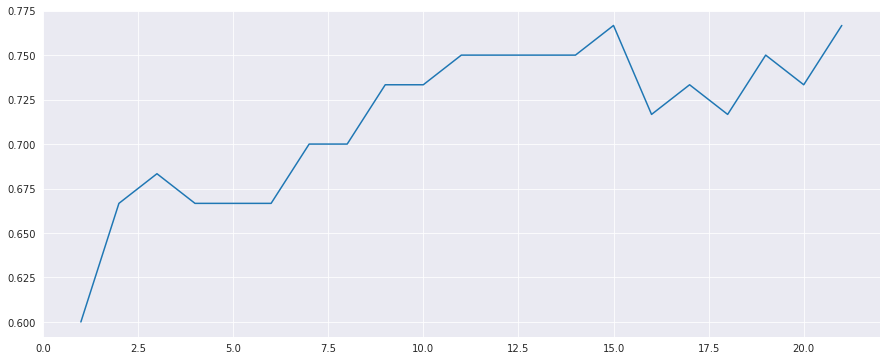

In [31]:
#Finding the optimum number of n_estimators // bron 1

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score
list1 = []
for estimators in range(1, 22):
    classifier = RandomForestClassifier(n_estimators = estimators, random_state=0)
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    list1.append(accuracy_score(y_test,y_pred))
plt.plot(list(range(1,22)), list1)
plt.show()

In [ ]:
#Random forest classifier
param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier()

CV_rfc = GridSearchCV(estimator=rf, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)
CV_rfc.best_params_

In [38]:
rfc = RandomForestClassifier(n_estimators=15, max_depth=5, criterion='gini', max_features='sqrt')
rfc.fit(X_train, y_train)
rf_pred = rfc.predict(X_test)

<Figure size 1080x432 with 0 Axes>

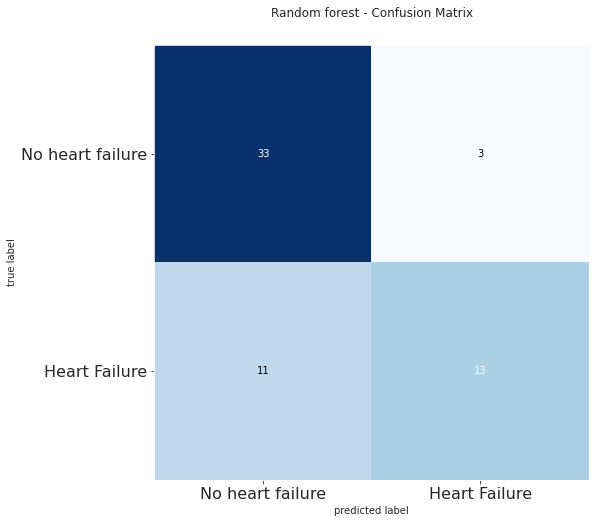

Accuracy: 0.766667
Precision: 0.941176
Recall: 0.666667
F1 score: 0.780488


In [39]:
cm = confusion_matrix(y_test, rf_pred)
plt.figure()
plot_confusion_matrix(cm, figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues)
plt.title("Random forest - Confusion Matrix")
plt.xticks(range(2), ["No heart failure","Heart Failure"], fontsize=16)
plt.yticks(range(2), ["No heart failure","Heart Failure"], fontsize=16)
plt.show()

rf_acc = accuracy_score(y_test, rf_pred)
print('Accuracy: %f' % rf_acc)
# precision tp / (tp + fp)
rf_precision = precision_score(y_test, dtc_pred)
print('Precision: %f' % rf_precision)

# recall: tp / (tp + fn)
rf_recall = recall_score(y_test, dtc_pred)
print('Recall: %f' % rf_recall)

# f1: 2 tp / (2 tp + fp + fn)
rf_f1 = f1_score(y_test, dtc_pred)
print('F1 score: %f' % rf_f1)

De random forest verschilt per sessie. De hoogste is %83.33333333333334.

#Conclusie

In [ ]:
#Conclusie
print(f'Decision tree: %{dtc_f1}')
print(f'Random forest: %{rf_f1}')

Uit bovenstaande resultaten is te zien dat de random forest het het beste gedaan heeft en de decision tree het slechtst. Ik had voorspeld dat de random forest classifier het beste resultaat zou geven vanwege hoge accuraatheid. Dit komt dus overeen met de voorspelling. Dit komt waarshcijnlijk doordat de random forest eigenlijk allemaal kleine desicion trees zijn.

#Bronnen

- Bron 1 - ideale leaf/node
  - https://www.kaggle.com/sanchitakarmakar/heart-failure-prediction-visualization
